In [1]:
# !pip install pds4_tools

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import math

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
from torch.utils.data import Dataset,DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch.optim import Adam,AdamW, SGD
from torch.optim.lr_scheduler import StepLR

from torchmetrics.functional import spectral_angle_mapper 


import albumentations as A
from albumentations.pytorch import ToTensorV2

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
path_hr = '/kaggle/input/ohrc-data/images_hr'
path_lr = '/kaggle/input/ohrc-data/images_lr'

In [4]:
len(os.listdir(path_hr))

128

# Data Visualization

Text(0.5, 1.0, 'Low Resolution')

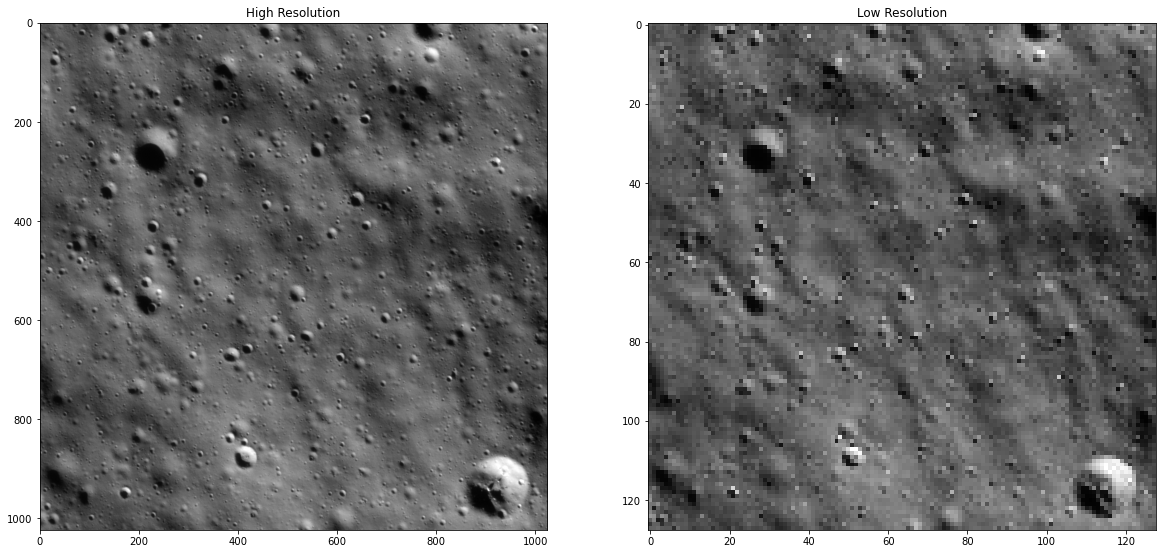

In [5]:
i = 78
plt.figure(figsize = (20, 20))
plt.subplot(1, 2, 1)
img_hr = cv2.imread(os.path.join(path_hr, f'image_{i}.png'))
plt.imshow(img_hr)
plt.title('High Resolution')
plt.subplot(1, 2, 2)
img_lr = cv2.imread(os.path.join(path_lr, f'image_{i}.png'))
plt.imshow(img_lr)
plt.title('Low Resolution')

In [6]:
# import pds4_tools
# structures = pds4_tools.read('/kaggle/input/dummy3/dir_2019/20191125/ch2_tmc_nca_20191125T0749024661_b_brw_d18.xml')  
# data = structures[0].data
# data.shape
# # plt.figure(figsize=(10, 40))
# # plt.imshow(data, cmap='gray')

# Dataset

In [7]:
class CFG:
    num_epochs = 4
    batch_size = 4
    size = 1024
    step_size = 2
    test_size = 0.3
    lr = 0.0001
    debug = False

In [8]:
class Dataset_(Dataset):
    def __init__(self, path_hr=path_hr, path_lr=path_lr, image_size = (1024, 1024), transform = None):
        self.path_hr = path_hr
        self.path_lr = path_lr
        self.image_size = image_size
        self.transform = transform
    
    def __len__(self):
        return len(os.listdir(self.path))
    
    def __getitem__(self, idx):
        image_hr = cv2.imread(os.path.join(path_hr, f'image_{idx}.png'))
        image_lr = cv2.imread(os.path.join(path_lr, f'image_{idx}.png'))
        image_hr  = cv2.cvtColor(image_hr, cv2.COLOR_BGR2RGB)
        image_lr  = cv2.cvtColor(image_lr, cv2.COLOR_BGR2RGB)
#         if self.transform :
#             augmented_hr = self.transform(image = image_hr)
#             augmented_lr = self.transform(image = image_lr)
#             image_hr = augmented_hr['image']
#             image_lr = augmented_lr['image']

        return torch.tensor(image_hr.transpose(2,0,1)).float(), torch.tensor(image_lr.transpose(2,0,1)).float()/255

In [9]:
# def get_transform(*,data):
#     if data=='Train':
#         return A.Compose([
#             A.Normalize(
#                 mean=[0.485, 0.456, 0.406],
#                 std=[0.229, 0.224, 0.225],
#             ),
#             ToTensorV2(),
#         ])

torch.Size([1, 1024, 1024])

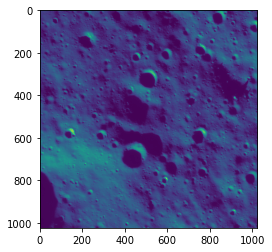

In [10]:
path_z = '/kaggle/input/ohrc-data/images_hr/image_0.png'
lr_z = cv2.imread(path_z)
gray_z = cv2.cvtColor(lr_z, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_z)
torch.tensor([gray_z]).shape

# Utility functions

# Model Utilities

In [11]:
# Vanilla Convolution Block
class ConvolutionalBlock(nn.Module):
    """
    A convolutional block, comprising convolutional, BN, activation layers.
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, batch_norm=False, activation=None):
        """
        :param in_channels: number of input channels
        :param out_channels: number of output channe;s
        :param kernel_size: kernel size
        :param stride: stride
        :param batch_norm: include a BN layer?
        :param activation: Type of activation; None if none
        """
        super(ConvolutionalBlock, self).__init__()

        if activation is not None:
            activation = activation.lower()
            assert activation in {'prelu', 'leakyrelu', 'tanh', 'sigmoid'}

        # A container that will hold the layers in this convolutional block
        layers = list()

        # A convolutional layer
        layers.append(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                      padding=kernel_size // 2))

        # A batch normalization (BN) layer, if wanted
        if batch_norm is True:
            layers.append(nn.BatchNorm2d(num_features=out_channels))

        # An activation layer, if wanted
        if activation == 'prelu':
            layers.append(nn.PReLU())
        elif activation == 'leakyrelu':
            layers.append(nn.LeakyReLU(0.2))
        elif activation == 'tanh':
            layers.append(nn.Tanh())
        elif activation == 'sigmoid':
            layers.append(nn.Sigmoid())

        # Put together the convolutional block as a sequence of the layers in this container
        self.conv_block = nn.Sequential(*layers)

    def forward(self, input):
        """
        Forward propagation.
        :param input: input images, a tensor of size (N, in_channels, w, h)
        :return: output images, a tensor of size (N, out_channels, w, h)
        """
        output = self.conv_block(input)  # (N, out_channels, w, h)

        return output


# Up-resolution
# First increasses the number of channels by r^2, where r is an upscale factor.
# Rearranges elements in a tensor of shape (∗,C×r^2,H,W) to a tensor of shape (∗,C,H×r,W×r), where r is an upscale factor.
class SubPixelConvolutionalBlock(nn.Module):
    """
    A subpixel convolutional block, comprising convolutional, pixel-shuffle, and PReLU activation layers.
    """

    def __init__(self, kernel_size=3, n_channels=64, scaling_factor=2):
        """
        :param kernel_size: kernel size of the convolution
        :param n_channels: number of input and output channels
        :param scaling_factor: factor to scale input images by (along both dimensions)
        """
        super(SubPixelConvolutionalBlock, self).__init__()

        # A convolutional layer that increases the number of channels by scaling factor^2, followed by pixel shuffle and PReLU
        self.conv = nn.Conv2d(in_channels=n_channels, out_channels=n_channels * (scaling_factor ** 2),
                              kernel_size=kernel_size, padding=kernel_size // 2)
        # These additional channels are shuffled to form additional pixels, upscaling each dimension by the scaling factor
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor=scaling_factor)
        self.prelu = nn.PReLU()

    def forward(self, input):
        """
        Forward propagation.
        :param input: input images, a tensor of size (N, n_channels, w, h)
        :return: scaled output images, a tensor of size (N, n_channels, w * scaling factor, h * scaling factor)
        """
        output = self.conv(input)
        output = self.pixel_shuffle(output)
        output = self.prelu(output) 

        return output

# Residual Block
# out = in -> Conv -> BN -> PReLu -> Conv -> BN
# out = out+in
class ResidualBlock(nn.Module):
    """
    A residual block, comprising two convolutional blocks with a residual connection across them.
    """

    def __init__(self, kernel_size=3, n_channels=64):
        """
        :param kernel_size: kernel size
        :param n_channels: number of input and output channels (same because the input must be added to the output)
        """
        super(ResidualBlock, self).__init__()

        # The first convolutional block
        self.conv_block1 = ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size,
                                              batch_norm=True, activation='PReLu')

        # The second convolutional block
        self.conv_block2 = ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size,
                                              batch_norm=True, activation=None)

    def forward(self, input):
        """
        Forward propagation.
        :param input: input images, a tensor of size (N, n_channels, w, h)
        :return: output images, a tensor of size (N, n_channels, w, h)
        """
        residual = input  # (N, n_channels, w, h)
        output = self.conv_block1(input)  # (N, n_channels, w, h)
        output = self.conv_block2(output)  # (N, n_channels, w, h)
        output = output + residual  # (N, n_channels, w, h)

        return output

# Model

In [12]:
class SRResNet(nn.Module):
    """
    The SRResNet, as defined in the paper.
    """

    def __init__(self, large_kernel_size=9, small_kernel_size=3, n_channels=64, n_blocks=16, scaling_factor=8):
        """
        :param large_kernel_size: kernel size of the first and last convolutions which transform the inputs and outputs
        :param small_kernel_size: kernel size of all convolutions in-between, i.e. those in the residual and subpixel convolutional blocks
        :param n_channels: number of channels in-between, i.e. the input and output channels for the residual and subpixel convolutional blocks
        :param n_blocks: number of residual blocks
        :param scaling_factor: factor to scale input images by (along both dimensions) in the subpixel convolutional block
        """
        super(SRResNet, self).__init__()

        # Scaling factor must be 2, 4, or 8
        scaling_factor = int(scaling_factor)
        assert scaling_factor in {2, 4, 8}, "The scaling factor must be 2, 4, or 8!"
        
        # The first convolutional block
        self.conv_block1 = ConvolutionalBlock(in_channels=3, out_channels=n_channels, kernel_size=large_kernel_size,
                                              batch_norm=False, activation='PReLu')

        # A sequence of n_blocks residual blocks, each containing a skip-connection across the block
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(kernel_size=small_kernel_size, n_channels=n_channels) for i in range(n_blocks)])

        # Another convolutional block
        self.conv_block2 = ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels,
                                              kernel_size=small_kernel_size,
                                              batch_norm=True, activation=None)

        # Upscaling is done by sub-pixel convolution, with each such block upscaling by a factor of 2
        n_subpixel_convolution_blocks = int(math.log2(scaling_factor))
        self.subpixel_convolutional_blocks = nn.Sequential(
            *[SubPixelConvolutionalBlock(kernel_size=small_kernel_size, n_channels=n_channels, scaling_factor=2) for i
              in range(n_subpixel_convolution_blocks)])

        # The last convolutional block
        self.conv_block3 = ConvolutionalBlock(
            in_channels=n_channels, 
            out_channels=3, 
            kernel_size=large_kernel_size,
            batch_norm=False, 
            activation='tanh')

    def forward(self, lr_imgs):
        """
        Forward prop.
        :param lr_imgs: low-resolution input images, a tensor of size (N, 3, w, h)
        :return: super-resolution output images, a tensor of size (N, 3, w * scaling factor, h * scaling factor)
        """
#         output_ = self.conv_block0(lr_imgs)  #(N,1,w,h)
        output = self.conv_block1(lr_imgs)  # (N, 3, w, h)
        residual = output  # (N, n_channels, w, h)
        output = self.residual_blocks(output)  # (N, n_channels, w, h)
        output = self.conv_block2(output)  # (N, n_channels, w, h)
        output = output + residual  # (N, n_channels, w, h)
        output = self.subpixel_convolutional_blocks(output)  # (N, n_channels, w * scaling factor, h * scaling factor)
        sr_imgs = self.conv_block3(output)  # (N, 3, w * scaling factor, h * scaling factor)

        return sr_imgs*255

In [13]:
def train_one_epoch(model, dataloader, loss_fn, optimizer, scheduler):
    train_loss = 0.0
    count = 0
    model.train()
    
    for image_hr, image_lr in tqdm(dataloader):
        
        image_hr, image_lr = image_hr.to(device), image_lr.to(device)
        optimizer.zero_grad()
        image_sr = model(image_lr)
        loss = loss_fn(image_sr, image_hr)
        loss.backward()
        optimizer.step()
        scheduler.step()
    
        train_loss += loss.item()
        count+=1
        
    return train_loss/count

def validate_one_epoch(model, dataloader, loss_fn): # = spectral_angle_mapper
    val_loss = 0.0
    count = 0
    model.eval()
    
    for image_hr, image_lr in tqdm(dataloader):
        
        image_hr, image_lr = image_hr.to(device), image_lr.to(device)
        image_sr = model(image_lr)
        loss = loss_fn(image_sr, image_hr)
    
        val_loss += loss.item()
        count+=1
        
    return val_loss/count

# Configuration

In [14]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [15]:
history = {'train_loss' : [], 'valid_loss' : []}
    
train_idx, test_idx = train_test_split(list(range(len(os.listdir(path_hr)))), test_size = CFG.test_size)
    
dataset = Dataset_()
train_loader = DataLoader(dataset,batch_size = CFG.batch_size, sampler = SubsetRandomSampler(train_idx))
val_loader = DataLoader(dataset, batch_size = 1, sampler = SubsetRandomSampler(test_idx))
    
model = SRResNet()
model.to(device)
optimizer = AdamW(model.parameters(), lr = CFG.lr)
# optimizer = SGD(model.parameters(), lr = CFG.lr)

scheduler = StepLR(optimizer = optimizer, step_size =CFG.step_size)
# loss_fn = spectral_angle_mapper
# loss_fn = nn.CosineEmbeddingLoss()
# loss_fn = nn.CrossEntropyLoss()
loss_fn = RMSELoss()

best_loss = np.inf
    
for epoch in range(CFG.num_epochs):
    train_loss = train_one_epoch(model, train_loader, loss_fn, optimizer, scheduler)
    valid_loss = validate_one_epoch(model, val_loader, loss_fn)
        
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
       
    print(f'Epoch : {epoch+1}/{CFG.num_epochs} | Training Loss : {train_loss} | Validation Loss : {valid_loss}')
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pth')

100%|██████████| 39/39 [00:05<00:00,  7.02it/s]


Epoch : 1/4 | Training Loss : 78.30273089201555 | Validation Loss : 86.14189118605394


100%|██████████| 39/39 [00:05<00:00,  7.06it/s]


Epoch : 2/4 | Training Loss : 76.96920477825662 | Validation Loss : 84.93434769068008


100%|██████████| 39/39 [00:05<00:00,  7.20it/s]


Epoch : 3/4 | Training Loss : 76.75635296365489 | Validation Loss : 83.178528321095


100%|██████████| 39/39 [00:05<00:00,  7.17it/s]

Epoch : 4/4 | Training Loss : 78.33300416365914 | Validation Loss : 82.56353348952074


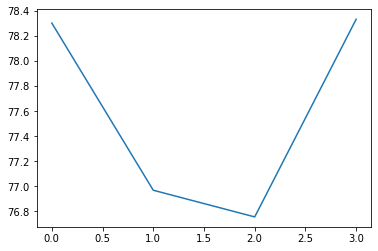

In [21]:
plt.plot(history['train_loss'])

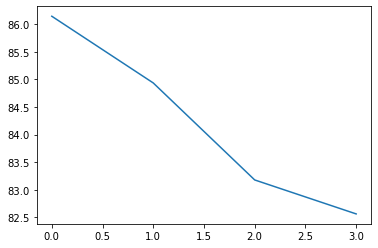

In [22]:
plt.plot(history['valid_loss'])

Text(0.5, 1.0, 'Super Resolution (Predict)')

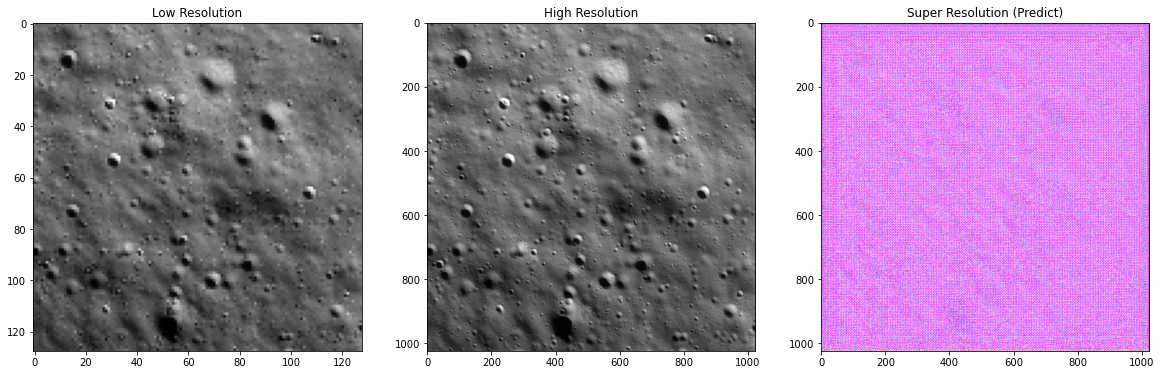

In [32]:
i = 70
img_hr = cv2.imread(os.path.join(path_hr, f'image_{i}.png'))
img_lr = cv2.imread(os.path.join(path_lr, f'image_{i}.png'))
img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)

model = SRResNet()
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

img_lr_ = torch.tensor([img_lr.transpose(2, 0, 1)]).float()

img_sr = model(img_lr_)

plt.figure(figsize = (20, 20))
plt.subplot(1, 3, 1)
plt.imshow(img_lr)
plt.title('Low Resolution')
plt.subplot(1, 3, 2)
plt.imshow(img_hr)
plt.title('High Resolution')
plt.subplot(1, 3, 3)
plt.imshow(img_sr.squeeze().detach().numpy().transpose(1, 2, 0), cmap ='gray')
plt.title('Super Resolution (Predict)')

In [33]:
i = img_sr.squeeze().detach().numpy().transpose(1, 2, 0)

In [34]:
print(i)

[[[ 245.28609   235.19958   253.74072 ]
  [ 254.90997   180.19371   254.98094 ]
  [ 254.9999   -254.91365  -245.87189 ]
  ...
  [ 240.5609   -255.       -254.475   ]
  [-254.99867   255.        253.32573 ]
  [ 247.14857   -94.07076   255.      ]]

 [[ 255.       -102.29215   254.97963 ]
  [ 255.        254.11127   255.      ]
  [ -39.97495  -254.99387  -250.38231 ]
  ...
  [ 254.99986  -254.9996    163.93834 ]
  [ 255.       -255.       -254.00949 ]
  [ 248.11816  -254.99667   252.18472 ]]

 [[ 255.        254.08653   254.99966 ]
  [ 255.        185.43306  -254.94269 ]
  [ 251.46132  -254.99988   255.      ]
  ...
  [ 255.       -255.       -254.99998 ]
  [ 137.99066   254.99995   255.      ]
  [-254.11761  -254.99976   255.      ]]

 ...

 [[ 238.17285   241.67606   254.99579 ]
  [ 253.79166  -254.76118   254.9597  ]
  [ 254.97786    32.588623  239.89441 ]
  ...
  [ 254.7306   -246.70636   254.96532 ]
  [-220.97856  -165.12025  -124.40759 ]
  [ 253.93486  -254.98778    31.981068]]

 [